In [1]:
import qiskit
# numerics
import numpy as np
# functional programmin tools
import itertools
import functools
import operator
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 125
import seaborn
# data analysis
import pandas as pd
# qiskit 
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import QasmSimulator, AerSimulator
from qiskit.quantum_info import Pauli
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.quantum_info import Kraus, SuperOp, SparsePauliOp, Operator, DensityMatrix, Statevector
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, depolarizing_error
from qiskit.circuit import ParameterVector

# Excercise 3.1 - QAOA

$G=(V,E)$, where $V=\{v_0,v_1,v_2,v_3 \}$ and $E=\{(v_0,v_1), (v_1,v_2), (v_0, v_2), (v_1,v_3), (v_2,v_3)) \}$. The Trotterized time evolution operator is

$$U= \prod_{m=1}^p U_M(\beta_m)U_f(\gamma_m)= exp(-i \beta_1 H_M \Delta t)exp(-i \gamma_1 H_f \Delta t) \cdots exp(-i \beta_p H_M \Delta t)exp(-i \gamma_p H_f \Delta t),$$

for $H_M=\sum_{i=1}^{\vert V \vert} X_i$ with ground state $\ket{+}^{\otimes \vert V \vert}$ and $H_f=\sum_{(u,v) \in E}Z_u Z_v$ with a ground state that encodes the solution to the MaxCut problem.

## Template to (a)

In [2]:
E = [(0, 1), (1, 2), (0, 2), (1, 3), (2, 3)]
V = [0, 1, 2, 3]

#To Do: Generate H_f and H_mix

In [3]:
basis_states = {}
ket = {0: Statevector([1, 0]), 1: Statevector([0, 1])}
for i, bitstring in enumerate(itertools.product([0, 1], repeat=4)):
    state = ket[bitstring[0]]
    for k in range(len(bitstring) - 1):
        state = state.tensor(ket[bitstring[k + 1]])
    basis_states[bitstring] = state
print(basis_states.keys())

dict_keys([(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1)])


In [4]:
#To Do: Calculate exact expectation values

## Template to (c)

In [5]:
# Create the QAOA circuit
def qaoa_circuit(gamma, beta,V , E):
    #To Do: Create QAOA circuit for gamma and beta and a given graph
    qc = QuantumCircuit()

    qc.measure_all()
    return qc

## Template to (d)

evaluate QAOA should do:

$c_{i,j,k,l}=(\frac{counts}{n-shots})^{1/2}$ for bitstring 'ijkl', such that $\sum_{i,j,k,l=0,1}\vert c_{i,j,k,l} \vert^{2}=1$


get state:
$\ket{\psi}=\sum_{i,j,k,l=0,1}c_{i,j,k,l} \ket{i,j,k,l}$ 


calculate expectation value:
$E=\bra{\psi}H_f \ket{\psi}=\sum_{i,j,k,l=0,1}\vert c_{i,j,k,l} \vert^2 \bra{i,j,k,l}H_f \ket{i,j,k,l}$

In [6]:
# Evaluate the QAOA circuit
def evaluate_qaoa(circuit, n_shots=1000):
    backend = AerSimulator()
    transpiled_qc = transpile(circuit, backend)
    qobj = assemble(transpiled_qc)

    result = backend.run(transpiled_qc).result()
    counts = result.get_counts(qc)
    
    #To Do: Calculate expectation value for a given result
    obj_val = 0
    
    return obj_val

# Optimize QAOA parameters with a grid search
def optimize_qaoa(V, E, n_shots=1000, n_steps=20):
    # Initial parameters, equidistant grid of gamma and beta
    gamma = np.linspace(0, np.pi, n_steps)
    beta = np.linspace(0, np.pi, n_steps)
    
    #To Do: get optimal values for gamma, beta and optimal (minimal) expectation value 
    
    return gamma_opt, beta_opt, obj_value_opt

In [7]:
# To Do: Run the optimization to get gamma_opt, beta_opt (replace assignment below)
gamma_opt = 0.0
beta_opt = 0.0

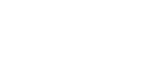

In [8]:
gamma=gamma_opt
beta=beta_opt

#run the circuit for optimal values
qc = qaoa_circuit(gamma, beta, V, E)
qc.measure_all()
qc.draw('mpl')

In [9]:
#To Do: get (noiseless) counts for the circuit using gamma_opt, beta_opt.

# Exercise 3.2

In [10]:
from scipy import linalg
from scipy.linalg import expm
from scipy.optimize import minimize

## Template (a)

In [11]:
#define X and Z Matrix
Z=np.array([[1,0],
  [0,-1]])
X=np.array([[0,1],
  [1,0]])

def g_1(s):
    y=np.sin(np.pi*s/2)**2
    return y

def Hamiltonian(s, schedule):
    #to do: get hamiltonian for a certain schedule function
    return H

def get_time_evol_operator(T, Hamiltonian, schedule):
    #to do: get time evolution operator for H until time T
    return U

def evolve(psi_initial, operator):
    # to do: evolve state psi_initial under time evol operator
    return psi_final

## Template (b)

In [12]:
minus = np.array([1/np.sqrt(2), -1/np.sqrt(2)])

def Fidelity_minus(state):
    # to do: compute fidelity F of input state w.r.t to minus
    return F


## Template (c)

In [13]:
#To Do: plot 1-fidelity


## Template (d)

In [14]:
# Repeat with the following schedule

def g_2(s):
    y=np.sin(np.pi*s/2)**4
    return y